In [7]:
import argparse
import gym
import cv2
import numpy as np
import pygame
from concurrent.futures import ThreadPoolExecutor

import ece471_duckhunt as dh
from ece471_duckhunt import envs
from ece471_duckhunt.envs import duckhunt_env


from solution import GetLocation

# Required version for the following packages
print(f"Duck Hunt version: {dh.__version__} (=1.0.0)")
print(f"OpenCV version: {cv2.__version__} (=4.X)")
print(f"NumPy version: {np.__version__} (=1.19+)")
print(f"OpenGym version: {gym.__version__} (=0.18.0)")


Duck Hunt version: 1.2.0 (=1.0.0)
OpenCV version: 4.5.5 (=4.X)
NumPy version: 1.21.5 (=1.19+)
OpenGym version: 0.18.0 (=0.18.0)


In [8]:
#Run main animation loop
#NOTE: I am not creating a threaded operation, see duck_hunt_main.py for demo code
""" 
Use the `current_frame` from either env.step of env.render
to determine where to move the scope.

current_frame : np.ndarray (width, height, 3), np.uint8, RGB
"""

#Fake a video card
os.environ["SDL_VIDEODRIVER"] = "dummy"


#Construct the Duck Hunt Environment
env = gym.make("DuckHunt-v0",
                    move_amount=1,
                    quiet=False,
                    level=1,
                    shape=(1024,798),
                    duration=60,
                    seed=None,
                    randomize=False,
                    )


game_done = False
#NOTE: bypassing this loop to use the threaded version in the next cell
while False: #not game_done:
        current_frame = env.render()
        
        """
        NOTE: This is a hack to display the scenes in Google Colab.
              I recommend using quiet=True or not displaying results
              and instead use Google Colab for training and your own computer
              for visualizing results
        """
        ##  convert from (width, height, channel) to (height, width, channel)
        #Display image, clear cell every 0.5 seconds
        output.clear()
        cv2_imshow(cv2.cvtColor(current_frame.transpose((1,0,2)), cv2.COLOR_RGB2BGR))
        
        
        #Using your algorithm, get a list of dictionaries with:
        # 'coordinate' : tuple or list (x,y) for absolute coordinates
        #                integer [0,8] for relative coordinates
        # 'move_type'  : type of move to perform
        results = GetLocation('absolute', env, current_frame)  

        """
        Pass the current location (and location type) you want the "gun" place.
        The action "shoot" is automatically done for you.
        Returns: 
                current_frame: np.dnarray (W,H,3), np.uint8, RGB: current frame after `coordinate` is applied.
                level_done: True if the current level is finished, False otw 
                game_done: True if all the levels are finished, False otw 
                info: dict containing current game information (see API guide)
        
        """
        for res in results:
            coordinate  = res['coordinate']
            move_type   = res['move_type']
            current_frame, level_done, game_done, info = env.step(coordinate, move_type)
            print(info)
            if level_done or game_done:
                break


Total number of levels: 820
{'length': 60, 'max_birds': 1, 'bird_speed': <BirdSpeed.slow: 1>, 'scene': ('foreground_alpha', 'background_1'), 'moving': False, 'atmosphere': [False, False, False, False], 'augment': [False, False, False, False], 'bamboozle': False, 'sprite-augment': [False, False, False], 'randomize': False, 'wind': False}
Level 1


Total number of levels: 820
{'length': 60, 'max_birds': 1, 'bird_speed': <BirdSpeed.slow: 1>, 'scene': ('foreground_alpha', 'background_1'), 'moving': False, 'atmosphere': [False, False, False, False], 'augment': [False, False, False, False], 'bamboozle': False, 'sprite-augment': [False, False, False], 'randomize': False, 'wind': False}
Level 1
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


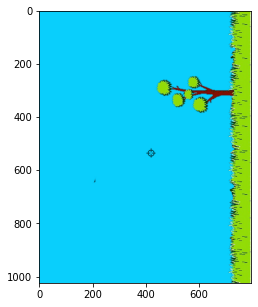

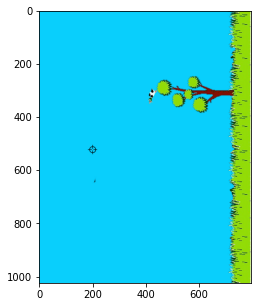

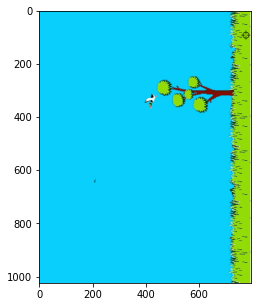

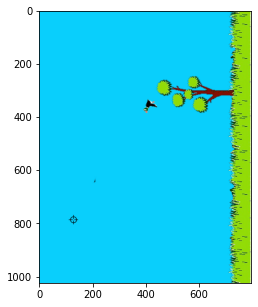

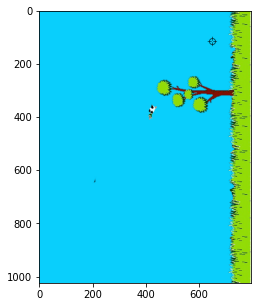

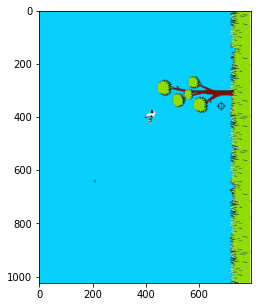

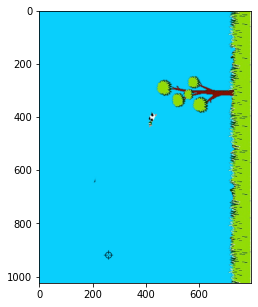

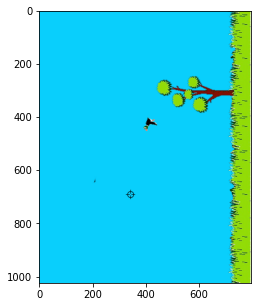

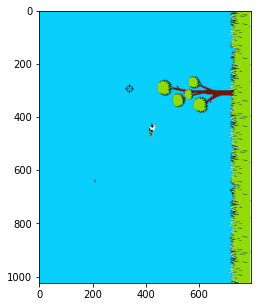

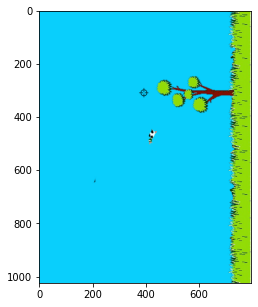

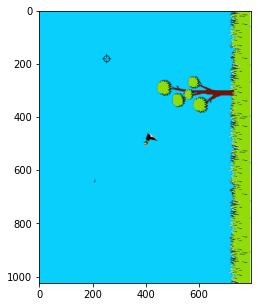

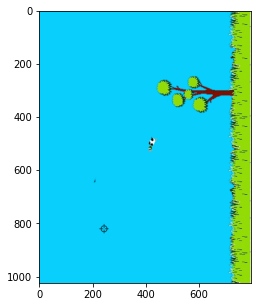

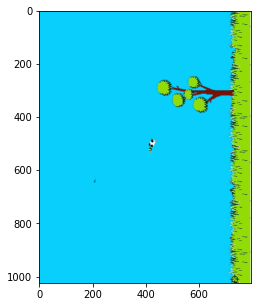

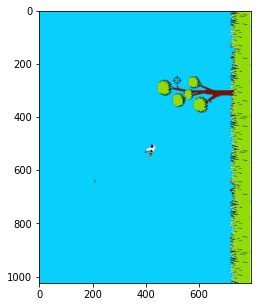

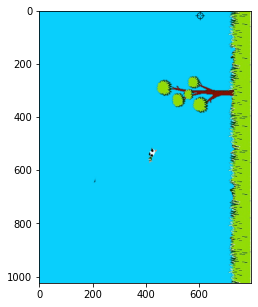

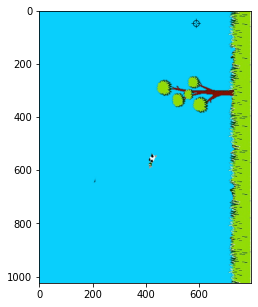

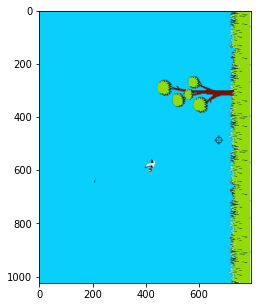

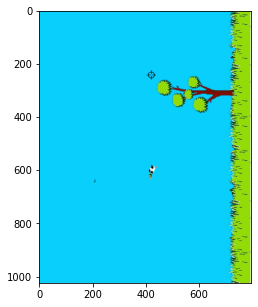

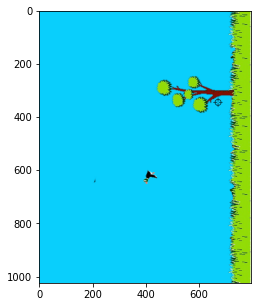

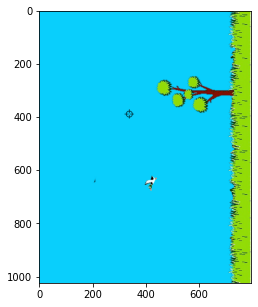

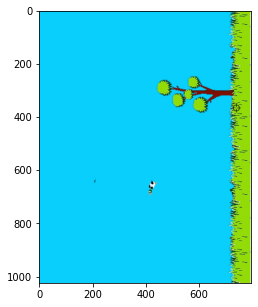

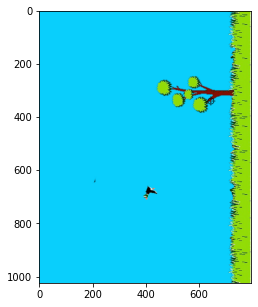

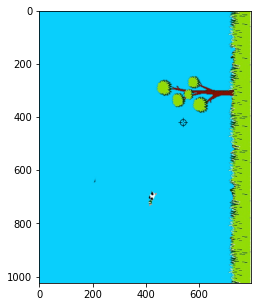

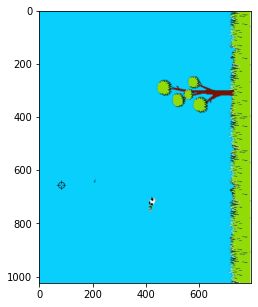

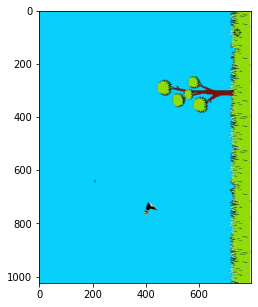

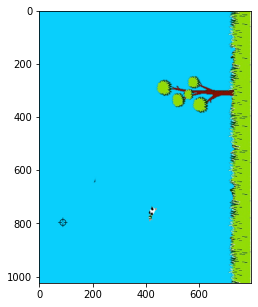

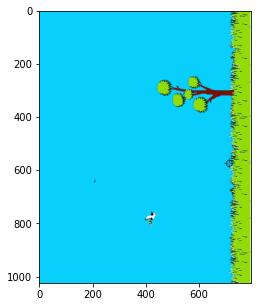

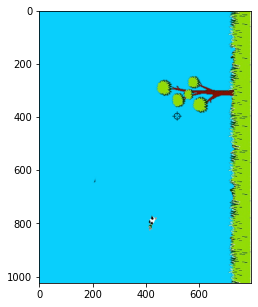

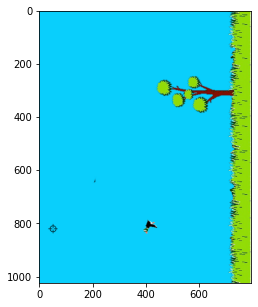

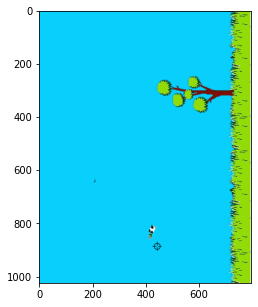

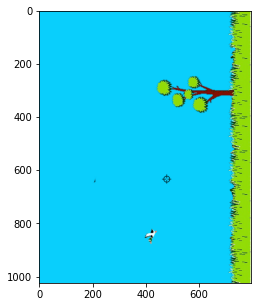

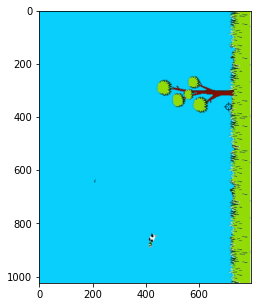

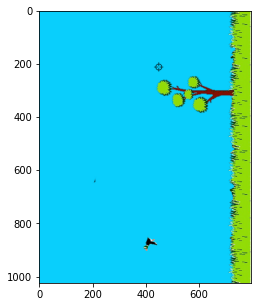

Finished all levels
Level done: True
Game done: True


In [12]:
#Run main animation loop
#NOTE: Threaded version
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt

#Fake a video card
os.environ["SDL_VIDEODRIVER"] = "dummy"
import pygame

""" If your algorithm isn't ready, it'll perform a NOOP """
def noop():
    return [{'coordinate' : 8, 'move_type' : 'relative'}]


""" 
Use the `current_frame` from either env.step of env.render
to determine where to move the scope.

current_frame : np.ndarray (width, height, 3), np.uint8, RGB
"""

""" Save the game as a GIF, for visualization purposes only!"""
from PIL import Image as PILImage
def save_gif(imgs, fn):
    pils = []
    for img in imgs:
        img = PILImage.fromarray(img)
        pils.append(img)

    pils[0].save(fn, save_all=True, append_images=pils[1:], duration=60, loop=0)



#NOTE: Once the game is over pygame is closed.  You need to re-create
# the game environment `env` before you can run another game.

#Construct the Duck Hunt Environment
env = gym.make("DuckHunt-v0",
                    move_amount=1,
                    quiet=False,
                    level=1,
                    shape=(1024,798),
                    duration=60,
                    seed=None,
                    randomize=False,
                    )



def runGame():
  frames = []
  indexer=1

  result = {}
  future = None
  executor = ThreadPoolExecutor(max_workers=1)

  game_done=False
  while not game_done:
          current_frame = env.render()
          
          """
          NOTE: This is a hack to display the scenes in Google Colab.
                I recommend using quiet=True or not displaying results
                and instead use Google Colab for training and your own computer
                for visualizing results
          """
          ##  convert from (width, height, channel) to (height, width, channel)
          #Display image, clear cell every 0.5 seconds
          #output.clear()
          #cv2_imshow(cv2.cvtColor(current_frame.transpose((1,0,2)), cv2.COLOR_RGB2BGR))
          
          #Saving the images for a GIF. 
          #Free Google Colab doesn't have enough resources for a 60s game so splitting
          #up the GIF. I didn't play with this so you could potentially increase it
          #Alternatively, you can save all frames to a mounted Google drive, and analyze
          #process them off-line
          #Or use a package like h5py and save and compress files as binary files
          frames.append(current_frame.transpose((1,0,2)))
          if len(frames) == 200:
              save_gif(frames, f"game_{indexer}.gif")
              frames = []
              indexer += 1

          #Using your algorithm, get a list of dictionaries with:
          # 'coordinate' : tuple or list (x,y) for absolute coordinates
          #                integer [0,8] for relative coordinates
          # 'move_type'  : type of move to perform
          
          if future is None:
            result = noop()



            plt.figure(figsize=(10,5))
            plt.imshow(current_frame)
            plt.show()
            


            future = executor.submit(GetLocation, 'absolute', env, current_frame)
          elif future.done():
            result = future.result()
            future = None


          """
          Pass the current location (and location type) you want the "gun" place.
          The action "shoot" is automatically done for you.
          Returns: 
                  current_frame: np.dnarray (W,H,3), np.uint8, RGB: current frame after `coordinate` is applied.
                  level_done: True if the current level is finished, False otw 
                  game_done: True if all the levels are finished, False otw 
                  info: dict containing current game information (see API guide)
          
          """
          for res in result:
              coordinate  = res['coordinate']
              move_type   = res['move_type']
              current_frame, level_done, game_done, info = env.step(coordinate, move_type)
              #print(info)
              if level_done or game_done:
                  print(f"Level done: {level_done}")
                  print(f"Game done: {game_done}")
                  #input("Press key to continue")
                  break
  if len(frames) > 0:
    save_gif(frames, f"game_{indexer}.gif")

%load_ext autoreload
%autoreload 2

runGame()


In [15]:
from modelTraining import ModelTraining
from preprocessing import Preprocessing

preprocessor = Preprocessing()

X, y = preprocessor.tag_data(file_path="data/")


trainer = ModelTraining()


data
----------
data/blue
----------
data/red
----------
data/black
----------
